In [2]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import seaborn as sns
import re
import statistics

%matplotlib inline 

# Some Notes regarding this data(census)

* I have included the data file layout in my data folder, so some of this is just repeated from there.
* The estimates are based on the 2010 Census and were created without incorporation or consideration of the 2020 Census results. 
* All geographic boundaries for these population estimates are as of January 1, 2020.
* An "A" in the 2010 Census field indicates a government that was formed or incorporated after the 2010 Census. 


In [3]:
og_df = pd.read_csv('../data/census/city_pop_est_2010_2020.csv')
city_pop = og_df

In [4]:
og_df.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532
1,162,1,0,124,0,0,0,A,Abbeville city,Alabama,...,2694,2645,2629,2610,2602,2587,2578,2565,2555,2553
2,162,1,0,460,0,0,0,A,Adamsville city,Alabama,...,4474,4453,4430,4399,4371,4335,4304,4285,4254,4211
3,162,1,0,484,0,0,0,A,Addison town,Alabama,...,750,745,744,742,734,734,728,725,723,717
4,162,1,0,676,0,0,0,A,Akron town,Alabama,...,347,347,344,338,338,335,332,332,328,327


In [5]:
# 'SUMLEV' code 40 will show the pop at a state level
state_pop = og_df[og_df['SUMLEV'] == 40]

In [6]:
state_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532
1109,40,2,0,0,0,0,0,A,Alaska,Alaska,...,722349,730810,737626,737075,738430,742575,740983,736624,733603,731158
1459,40,4,0,0,0,0,0,A,Arizona,Arizona,...,6473416,6556344,6634690,6732873,6832810,6944767,7048088,7164228,7291843,7421401
1680,40,5,0,0,0,0,0,A,Arkansas,Arkansas,...,2941038,2952876,2960459,2968759,2979732,2991815,3003855,3012161,3020985,3030522
2853,40,6,0,0,0,0,0,A,California,California,...,37636311,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39368078


# Time to explore some of this data
\
I want to start with Nashville's population and find cities with similar sizes. \
+- 10% of Nashville's pop should be good for cities within similar size

In [7]:
city_pop['SUMLEV'].value_counts()

157    23705
61     21062
162    19494
71     13837
50      3143
172      115
40        51
170        8
Name: SUMLEV, dtype: int64

In [8]:
'''
I will be using 'SUMLEV' 162 because that is the instance that specifies that entry is an 'incorporated place'

The census defines an 'incorporated place' as:
    "An incorporated place, under the Census Bureau's definition,[2] is a type of governmental unit incorporated under state law as a city, town (except the New England states, New York, and Wisconsin),[3] borough (except in Alaska and New York),
    [4] or village, and having legally prescribed limits, powers, and functions".
'''

city_pop = city_pop[city_pop['SUMLEV'] == 162]

In [9]:
# Dropping some unnecessary columns
city_pop = city_pop.drop(columns=['SUMLEV','STATE', 'COUNTY', 'PLACE', 'COUSUB', 'CONCIT', 'PRIMGEO_FLAG', 'FUNCSTAT'])

# Renaming some columns
city_pop = city_pop.rename(columns={"NAME": "CITY", "STNAME": "STATE"})

In [10]:
# Filtering by 2 criteria, trying to narrow down Nashville down to those within TN
# df loc - locate within this df the following: under the 'NAME' column, find all strings that contain 'Nashville'. Under the 'STNAME' column, limit it TN
nash_pop = city_pop.loc[(city_pop['CITY'].str.contains("Nashville")) & (city_pop['STATE']=='Tennessee')]

In [11]:
nash_pop

,CITY,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,601222,603465,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [14]:
city_2020_pop = city_pop[['CITY', 'STATE', 'POPESTIMATE2020']]
city_2020_pop

,CITY,STATE,POPESTIMATE2020
1,Abbeville city,Alabama,2553
2,Adamsville city,Alabama,4211
3,Addison town,Alabama,717
4,Akron town,Alabama,327
5,Alabaster city,Alabama,33701
...,...,...,...
81264,Wamsutter town,Wyoming,467
81265,Wheatland town,Wyoming,3522
81266,Worland city,Wyoming,4994
81267,Wright town,Wyoming,1758


In [13]:
# Nash 2020 Pop Estimate
nash_2020_pop = nash_pop[['CITY', 'STATE', 'POPESTIMATE2020']]
nash_2020_pop

,CITY,STATE,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295


In [20]:
# let's look at cities similar to Nash in terms of pop. I will use 10% (plus or minus) Nash Pop

nash_2020_pop['Plus_10'] = nash_2020_pop['POPESTIMATE2020']*1.1
nash_2020_pop['Minus_10'] = nash_2020_pop['POPESTIMATE2020']*0.9
nash_2020_pop

<ipython-input-20-1eccd2e6f804>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_2020_pop['Plus_10'] = nash_2020_pop['POPESTIMATE2020']*1.1
<ipython-input-20-1eccd2e6f804>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_2020_pop['Minus_10'] = nash_2020_pop['POPESTIMATE2020']*0.9


,CITY,STATE,POPESTIMATE2020,Plus_10,Minus_10
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295,738424.5,604165.5


In [27]:
# I hard coded the number into the code. I was getting an error trying to point it to 'nash_2020_pop['Plus_10']'. I also rounded up to the next whole number. 

similar_size_cities = city_2020_pop[((city_2020_pop['POPESTIMATE2020'] <= 738425) & (city_2020_pop['POPESTIMATE2020'] >= 604166))]
similar_size_cities

,CITY,STATE,POPESTIMATE2020
3996,Denver city,Colorado,735538
5034,Washington city,District of Columbia,712816
25634,Louisville/Jefferson County metro government (...,Kentucky,618338
28330,Boston city,Massachusetts,691531
28996,Detroit city,Michigan,665369
43978,Las Vegas city,Nevada,662368
59874,Oklahoma City city,Oklahoma,662314
61026,Portland city,Oregon,656751
70434,Memphis city,Tennessee,649705
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295


In [34]:
nash_pop

,CITY,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,601222,603465,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [75]:
# I want to do a quick visualization for Nash pop over the years. 

k = nash_pop.drop(columns = ['CITY', 'STATE', 'CENSUS2010POP', 'ESTIMATESBASE2010'])
transpose = k.T.reset_index()

In [76]:
transpose

,index,70455
0,POPESTIMATE2010,604644
1,POPESTIMATE2011,612689
2,POPESTIMATE2012,625824
3,POPESTIMATE2013,636375
4,POPESTIMATE2014,645741
5,POPESTIMATE2015,656089
6,POPESTIMATE2016,662344
7,POPESTIMATE2017,664220
8,POPESTIMATE2018,667772
9,POPESTIMATE2019,669725


In [77]:
# Let's clean this up

transpose = transpose.rename(columns={"index": "Year", 70455: "Estimated_Pop"})
transpose['Year'] = transpose.Year.str.replace('POPESTIMATE','')

In [78]:
transpose.info()
transpose['Estimated_Pop'] = transpose['Estimated_Pop'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           11 non-null     object
 1   Estimated_Pop  11 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


Text(0.5, 1.0, 'Nashville Estimate Population')

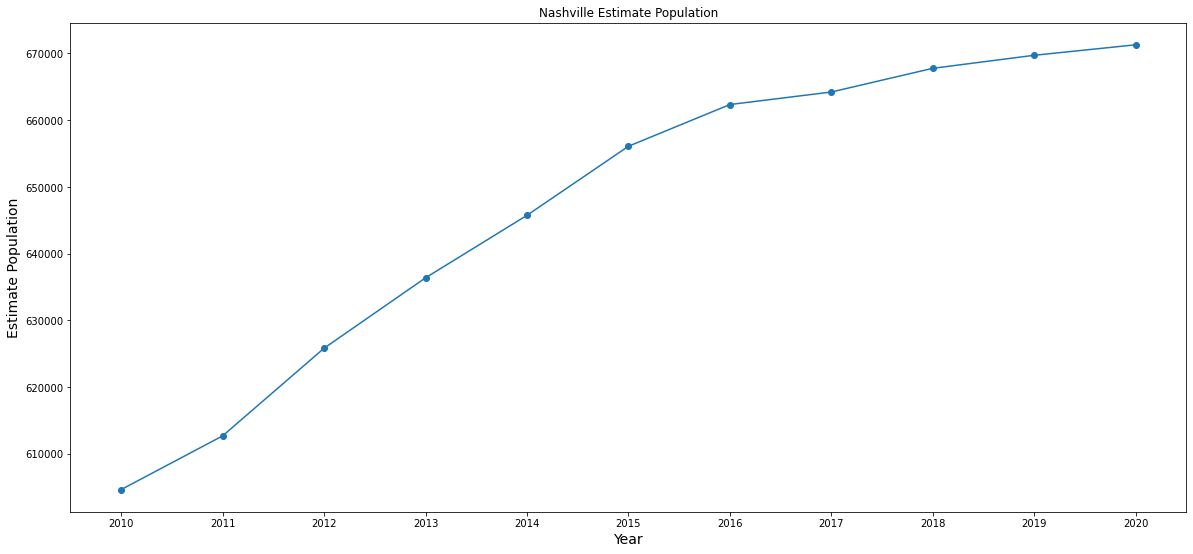

In [89]:
plt.figure(figsize=(20, 9))


plt.plot(
    transpose['Year'],
    transpose['Estimated_Pop'],
    marker = 'o'
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Estimate Population", fontsize=14)
plt.title('Nashville Estimate Population')